Open this [link](https://rl-lab.com/multi-armed-bandits/)

In [2]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [3]:
class BernoulliBandit:
  def __init__(self, n_actions=5):
    self._probs = np.random.random(n_actions)
  
  @property
  def action_count(self):
    return len(self._probs)
  
  def pull(self, action):
    if np.random.random() < self._probs[action]:
      return 1.0
    return 0.0

  def optimal_reward(self):
    return np.max(self._probs)
  
  def reset(self):
    pass
  def step(self):
    pass


In [4]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions=5):
      self._successes = np.zeros(n_actions)
      self._failures = np.zeros(n_actions)
      self._total_pulls = 0
      self.n_actions = n_actions


    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        if reward == 1:
          self._successes[action] += 1
        else: self._failures[action] += 1

        self._total_pulls += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(self.n_actions)

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [5]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.random() < self._epsilon:
          return np.random.randint(self.n_actions)
        else:
          return np.argmax(self._successes / (self._successes + self._failures + 0.1))


    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy have no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents optimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [6]:
class UCBAgent(AbstractAgent):
    def get_action(self):
      pulls = self._failures + self._successes + 1e-5
      return np.argmax(self._successes / pulls +\
                       np.sqrt(2 * np.log(self._total_pulls + 1e-5) / pulls))

## Homework
Your assignment is to solve the Bernoulli Bandit problem using Thompson sampling algorithm.

1- Based on your understanding write down the pseudo-code for Thompson sampling algorithm.

2- Implement the `get_action(self)` in the cell below.

3- Explain in detail the results you got in comparison with UCB and $\epsilon$-Greedy.


**Note:** Your grade will be based on your understanding of the algorithm and your analysis to the results. Cheating will be punished by 50% deduction for the first time and will get 0 in the second time. 

### Thompson sampling
< Write Your Solution HERE >

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [7]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        """
        <Write Your Solution Here>
        """
        pass

In [8]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
      agent.name: [0.0]*n_steps for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for agent in agents:
            agent.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


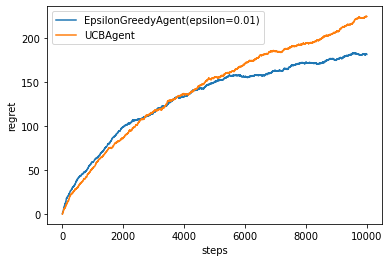

In [9]:
# Uncomment agents
agents = [
    EpsilonGreedyAgent(),
    UCBAgent(),
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)